# An experimental area for adjacency matrix



In [26]:
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.metrics.cluster import contingency_matrix
from matplotlib import pyplot as plt


def bd_demomposition(adj):
    """Birth-death decomposition."""
    eps = np.nextafter(0, 1)
    adj[adj == 0] = eps
    adj = np.triu(adj, k=1)
    Xcsr = csr_matrix(-adj)
    Tcsr = minimum_spanning_tree(Xcsr)
    mst = -Tcsr.toarray()  # reverse the negative sign
    nonmst = adj - mst
    return mst, nonmst
def compute_birth_death_sets(adj):
    """Computes birth and death sets of a network."""
    mst, nonmst = bd_demomposition(adj)
    birth_ind = np.nonzero(mst)
    death_ind = np.nonzero(nonmst)
    return np.sort(mst[birth_ind]), np.sort(nonmst[death_ind])

def get_barcode(adj):
    """Computes topological clustering and predicts cluster index for each sample.
        
            Args:
                data:
                  Training instances to cluster.
                  
            Returns:
                Cluster index each sample belongs to.
    """
    # Networks represented as vectors concatenating geometric and topological info
    X = []
    X.append(compute_birth_death_sets(adj))
    # Return X directly without converting to a NumPy array
    return X 
# Visualization
def plot_barcode(births, deaths, title="Barcode"):
    plt.figure(figsize=(10, 5))  # Increased figure size for clarity
    for i, (birth, death) in enumerate(zip(births, deaths)):
        plt.plot([birth, death], [i, i], 'k', lw=0.5, alpha=0.5)  # Decreased line width and added transparency
    plt.title(title)
    plt.xlabel("Feature Lifetime")
    plt.ylabel("Feature Index")
    plt.grid(True)
    plt.yticks([])  # Remove y-ticks for clarity
    plt.tight_layout()  # Adjust layout to fit the figure size
    plt.show()

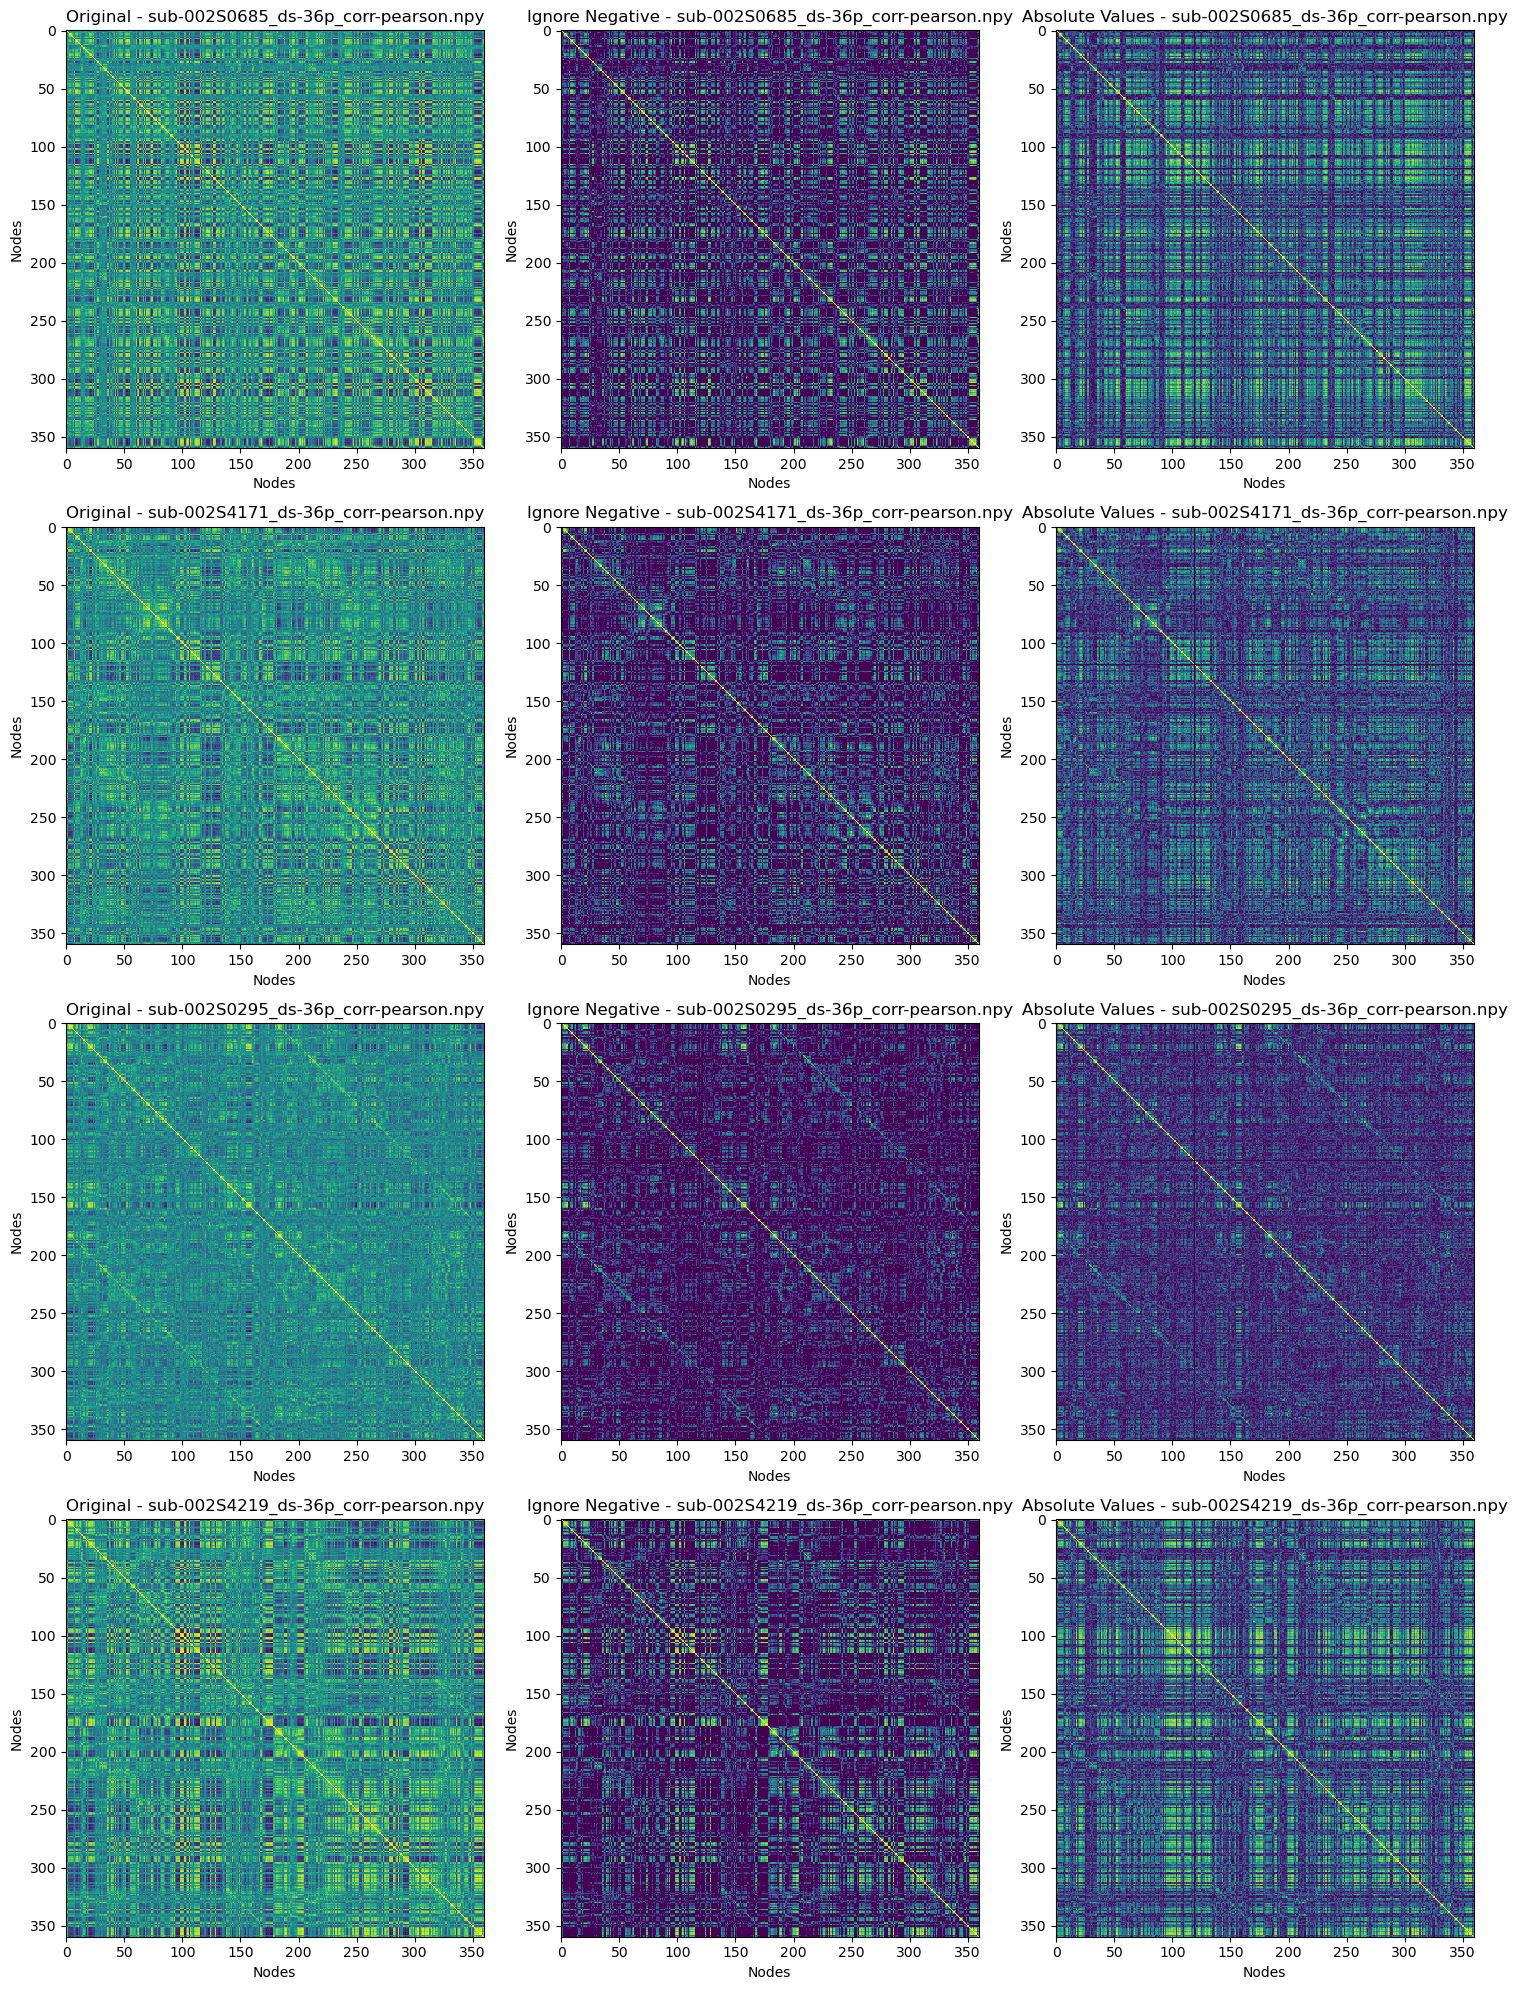

In [10]:

# Directory containing the .npy files
directory_path = '/home/bqshi/workspace/fmri_topolearn/data/04_correlations/corr-pearson/ds-36p'

# List all files in the directory
files = [f for f in os.listdir(directory_path) if f.endswith('.npy')]
num_files = len(files)

# Set the width and height of the grid
grid_width = 3
grid_height = num_files

# Create a figure to hold all subplots
fig, axs = plt.subplots(grid_height, grid_width, figsize=(15, 5 * grid_height))

# Loop through each file
for i, file_name in enumerate(files):
    # Construct the full file path
    file_path = os.path.join(directory_path, file_name)
    
    # Load the adjacency matrix from the .npy file
    adjacency_matrix = np.load(file_path)
    
    # Plot the original matrix
    axs[i, 0].imshow(adjacency_matrix, cmap='viridis', interpolation='nearest')
    axs[i, 0].set_title(f"Original - {file_name}")
    axs[i, 0].set_xlabel("Nodes")
    axs[i, 0].set_ylabel("Nodes")

    # Ignore negative values and plot
    adjacency_matrix_non_negative = np.where(adjacency_matrix < 0, 0, adjacency_matrix)
    axs[i, 1].imshow(adjacency_matrix_non_negative, cmap='viridis', interpolation='nearest')
    axs[i, 1].set_title(f"Ignore Negative - {file_name}")
    axs[i, 1].set_xlabel("Nodes")
    axs[i, 1].set_ylabel("Nodes")

    # Take absolute values and plot
    adjacency_matrix_abs = np.abs(adjacency_matrix)
    axs[i, 2].imshow(adjacency_matrix_abs, cmap='viridis', interpolation='nearest')
    axs[i, 2].set_title(f"Absolute Values - {file_name}")
    axs[i, 2].set_xlabel("Nodes")
    axs[i, 2].set_ylabel("Nodes")
    
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

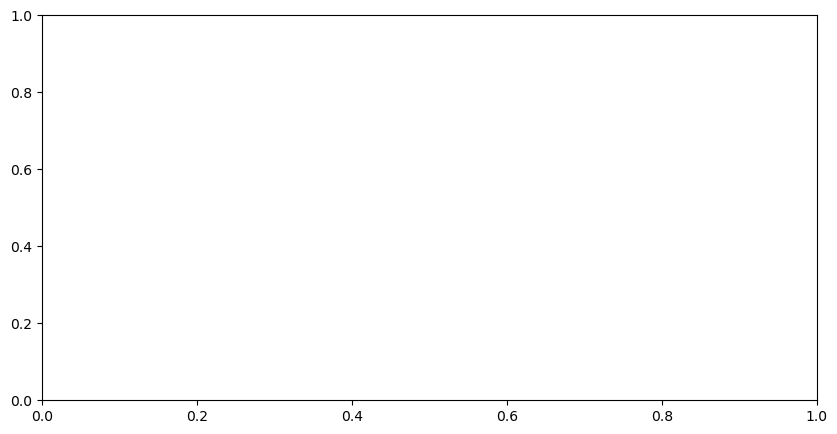

In [27]:
# Loop through each file
barcode_map = {}

def vectorize_topological_info(adj):
    birth_set, death_set = compute_birth_death_sets(adj)  # topological info
    return np.concatenate((birth_set, death_set), axis=0)

for i, file_name in enumerate(files):
    # Construct the full file path
    file_path = os.path.join(directory_path, file_name)
    
    # Load the adjacency matrix from the .npy file
    adjacency_matrix = np.load(file_path)
    # Extracting births and deaths from the barcode data for the first (and only) dataset
    barcode_data = get_barcode(adjacency_matrix)
    births, deaths = barcode_data[0]
    plot_barcode(births, deaths, "Original Matrix Barcode: " + file_name[:12])

    # Ignore negative values and plot
    adjacency_matrix_non_negative = np.where(adjacency_matrix < 0, 0, adjacency_matrix)
    
    barcode_data_nn = get_barcode(adjacency_matrix_non_negative)
    births_nn, deaths_nn = barcode_data_nn[0]
    plot_barcode(births_nn, deaths_nn, "Non-negative Matrix Barcode: " + file_name[:12])

    # Take absolute values and plot
    adjacency_matrix_abs = np.abs(adjacency_matrix)
    
    barcode_data_abs = get_barcode(adjacency_matrix_abs)
    births_abs, deaths_abs = barcode_data_abs[0]
    plot_barcode(births_abs, deaths_abs, "Absolute Matrix Barcode: " + file_name[:12])
    
    barcode_map[file_name[4:12]] = vectorize_topological_info(adjacency_matrix_abs)

In [24]:
barcode_map

{'002S0685': array([4.94065646e-324, 3.09449958e-001, 3.69293485e-001, ...,
        9.32255995e-001, 9.41906968e-001, 9.44483906e-001]),
 '002S4171': array([4.94065646e-324, 4.24347372e-001, 4.39322299e-001, ...,
        8.71215307e-001, 8.77112065e-001, 8.78353164e-001]),
 '002S0295': array([4.94065646e-324, 3.65077118e-001, 3.70245641e-001, ...,
        8.69736168e-001, 8.74602233e-001, 9.15463797e-001]),
 '002S4219': array([4.94065646e-324, 3.92079317e-001, 4.38958324e-001, ...,
        9.61129652e-001, 9.63733339e-001, 9.65079667e-001])}

In [16]:
labels = {"002S4219":"LMCI","002S0685":"CN","002S4171":"LMCI","002S4219":"CN"}

In [ ]:
def fit_predict(data):
    data = np.asarray(data)
    n_node = data.shape[1]
    n_edges = math.factorial(n_node) // math.factorial(2) // math.factorial(
        n_node - 2)  # n_edges = (n_node choose 2)
    n_births = n_node - 1
    top_relative_weight = 0.99
    weight_array = np.append(
        np.repeat(1 - top_relative_weight, n_edges),
        np.repeat(top_relative_weight, n_edges))

    # Networks represented as vectors concatenating geometric and topological info
    X = []
    for adj in data:
        X.append(self._vectorize_geo_top_info(adj))
    X = np.asarray(X)

    # Random initial condition
    centroids = X[random.sample(range(X.shape[0]), n_clusters)]

    # Assign the nearest centroid index to each data point
    assigned_centroids = self._get_nearest_centroid(
        X[:, None, :], self.centroids[None, :, :])
    prev_assigned_centroids = assigned_centroids

    for it in range(self.max_iter_alt):
        for cluster in range(self.n_clusters):
            # Previous iteration centroid
            prev_centroid = np.zeros((n_node, n_node))
            prev_centroid[np.triu_indices(
                prev_centroid.shape[0],
                k=1)] = self.centroids[cluster][:n_edges]

            # Determine data points belonging to each cluster
            cluster_members = X[assigned_centroids == cluster]

            # Compute the sample mean and top. centroid of the cluster
            cc = cluster_members.mean(axis=0)
            sample_mean = np.zeros((n_node, n_node))
            sample_mean[np.triu_indices(sample_mean.shape[0],
                                        k=1)] = cc[:n_edges]
            top_centroid = cc[n_edges:]
            top_centroid_birth_set = top_centroid[:n_births]
            top_centroid_death_set = top_centroid[n_births:]

            # Update the centroid
            try:
                cluster_centroid = self._top_interpolation(
                    prev_centroid, sample_mean, top_centroid_birth_set,
                    top_centroid_death_set)
                self.centroids[cluster] = self._vectorize_geo_top_info(
                    cluster_centroid)
            except:
                print(
                    'Error: Possibly due to the learning rate is not within appropriate range.'
                )
                sys.exit(1)

        # Update the cluster membership
        assigned_centroids = self._get_nearest_centroid(
            X[:, None, :], self.centroids[None, :, :])

        # Compute and print loss as it is progressively decreasing
        loss = self._compute_top_dist(
            X, self.centroids[assigned_centroids]).sum() / len(X)
        print('Iteration: %d -> Loss: %f' % (it, loss))

        if (prev_assigned_centroids == assigned_centroids).all():
            break
        else:
            prev_assigned_centroids = assigned_centroids
    plt.figure(figsize=(10, 7))
    for i, adj in enumerate(data):
        # Assuming each adj matrix corresponds to a data point and has a unique identifier
        # Extract the identifier from your data structure
        subject_id = "Your method to get subject ID from adj"  # Placeholder
        label = labels[subject_id]
        cluster = assigned_centroids[i]
        
        # Generate mockup locations for each barcode/data point for demonstration purposes
        # Replace this with your actual method of determining positions if applicable
        x, y = np.random.rand(2)  # Placeholder for actual positions
        
        plt.scatter(x, y, c=f'C{cluster}', label=f'{label} ({subject_id})', alpha=0.6, edgecolors='w')

    # Improve the legend to show unique labels only
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title('Barcode Clustering Visualization')
    plt.xlabel('X Coordinate (Mockup)')
    plt.ylabel('Y Coordinate (Mockup)')
    plt.show()

    return assigned_centroids

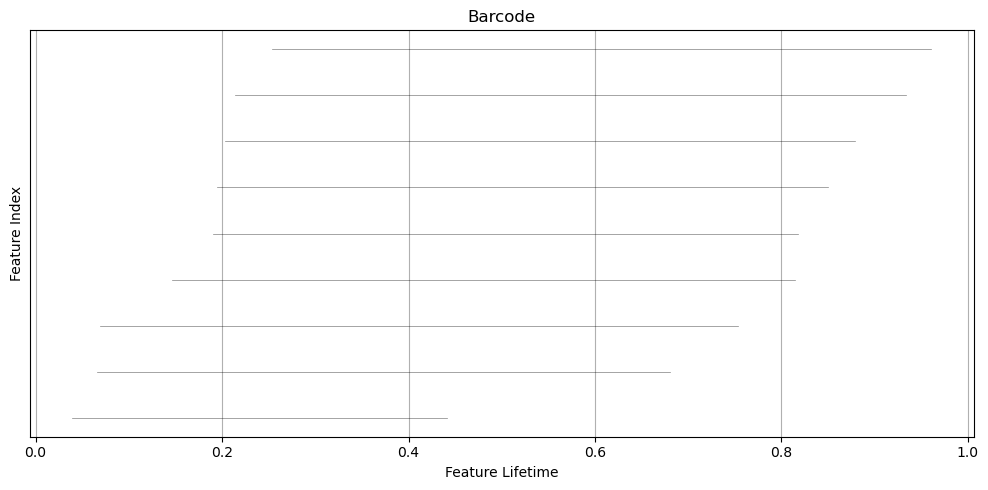

In [25]:
# Sample adjacency matrix for demonstration

np.random.seed(0)  # For reproducibility
size = 10  # Smaller size for simplicity
sample_adj = np.random.rand(size, size)
sample_adj = (sample_adj + sample_adj.T) / 2  # Make it symmetric
np.fill_diagonal(sample_adj, 0)  # Remove self-loops

sample_barcode = get_barcode(sample_adj)
sample_b, sample_d = sample_barcode[0]
plot_barcode(sample_b, sample_d)
